In [34]:
from imdb import IMDb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import time
import os
from pathlib import Path
from ipdb import set_trace
from itertools import combinations
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import time
import sys
from mpl_toolkits.axes_grid1 import make_axes_locatable

pd.options.mode.chained_assignment = None

#### Data Acquisition and Setup

In [3]:
imdb_data = pd.read_csv('imdb_data.csv')
imdb_data.dropna(axis=0)
imdb_data.sort_values('releaseYear', inplace=True)

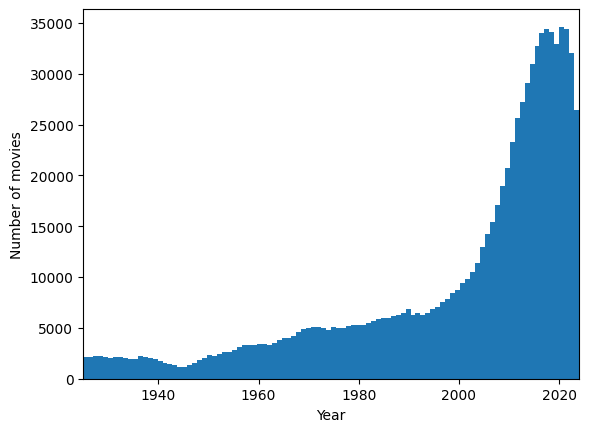

In [4]:
start_year, end_year = 1925, 2024
plt.hist(imdb_data.query('releaseYear >= @start_year and releaseYear <= @end_year')['releaseYear'], bins=end_year-start_year+1)
plt.gca().set(xlabel='Year', ylabel='Number of movies', xlim=[start_year, end_year])
plt.show()

In [5]:
run_this_cell = False # Only use this cell for dataset acquisition. Otherwise, turn it off so it doesn't accidentally get run.

posters_per_year = 100
MAX_PIXELS = 89478485
if run_this_cell:
    start_time = time.time()
    ia = IMDb()
    for year in np.arange(1925, 2025, dtype=float):
        year_start_time = time.time()
        data_year = imdb_data.query('type == "movie" and releaseYear == @year')
        successful_queries, failed_queries = 0, 0
        iter = 0
        while successful_queries < posters_per_year:
            movie_id = data_year['id'].iloc[iter]
            try:
                movie = ia.get_movie(movie_id[2:])
                poster_url = movie.get('full-size cover url')
                response = requests.get(poster_url)
                img = Image.open(BytesIO(response.content))
                if np.prod(img.size) > MAX_PIXELS:
                    raise Exception('Poster is too large')
                if img.mode != 'RGB':
                    raise Exception('Poster not in RGB')
                filename = f'century_poster_dataset/{movie_id}.jpg'
                img.save(filename)
                successful_queries += 1
            except Exception:
                failed_queries += 1
            iter += 1
        now = time.time()
        num_mins1, num_mins2 = (now - year_start_time) // 60, (now - start_time) // 60
        num_secs1, num_secs2 = (now - year_start_time) % 60, (now - start_time) % 60
        print(f'Completed year {int(year)} in {int(num_mins1)}:{int(num_secs1):02d} with {failed_queries} failed queries. ({int(num_mins2)}:{int(num_secs2):02d} overall so far)')

In [6]:
ids_with_posters = os.listdir('century_poster_dataset')
ids_with_posters = [i[:i.rindex('.')] for i in ids_with_posters]
data_with_posters = imdb_data.query('id in @ids_with_posters & type == "movie"')
data_with_posters

,id,title,type,genres,averageRating,numVotes,releaseYear
267180,tt0877727,Vampires of Warsaw,movie,"Crime, Drama",3.4,8.0,1925.0
197812,tt0333730,Kivalina of the Ice Lands,movie,"Action, Adventure, Drama",4.6,22.0,1925.0
198457,tt0335314,No Rastro do Eldorado,movie,Documentary,7.2,10.0,1925.0
96415,tt0132207,Hedda Gabler,movie,Drama,NaN,NaN,1925.0
96344,tt0132085,The Devil in the City,movie,Drama,6.0,32.0,1925.0
...,...,...,...,...,...,...,...
766441,tt33143789,Bae Dard,movie,Comedy,NaN,NaN,2024.0
638408,tt26659814,Auron Mein Kahan Dum Tha,movie,"Action, Crime, Drama",6.8,40047.0,2024.0
693658,tt29520053,Point of the Pen,movie,"Action, Documentary, Music",NaN,NaN,2024.0
693744,tt29521968,Mina and the Radio Bandits,movie,Documentary,7.9,17.0,2024.0


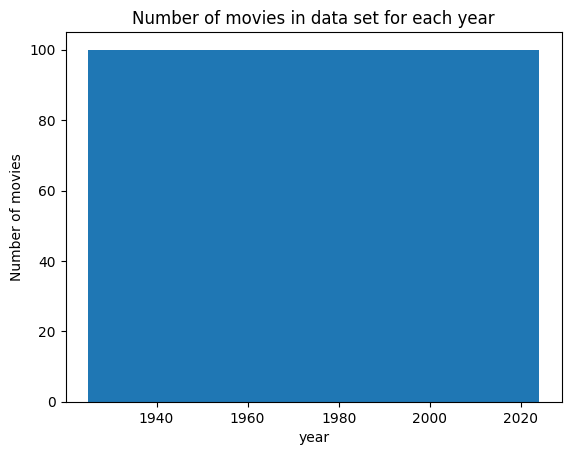

In [7]:
plt.hist(data_with_posters['releaseYear'], bins=len(data_with_posters['releaseYear'].unique()))
plt.gca().set(xlabel='year', ylabel='Number of movies', title='Number of movies in data set for each year')
plt.show()

In [8]:
def sample_movies_by_year(df, start_year, end_year, n, year_column='releaseYear'):
    filtered_df = df[(df[year_column] >= start_year) & (df[year_column] <= end_year)]
    sampled_df = (filtered_df.groupby(year_column, group_keys=False).apply(lambda group: group.sample(n=n, random_state=42)))
    return sampled_df.reset_index(drop=True)

In [9]:
data_with_posters.shape

(10000, 7)

In [10]:
train_df, test_df = train_test_split(data_with_posters, test_size=0.3, stratify=data_with_posters['releaseYear'], random_state=42)

In [11]:
def generate_id_pairs_by_year(df, id_column='id', year_column='releaseYear'):
    year_to_ids = df.groupby(year_column)[id_column].apply(list).to_dict()
    year_combinations = list(combinations(year_to_ids.keys(), 2))
    pairs = []
    for year1, year2 in year_combinations:
        ids1 = year_to_ids[year1]
        ids2 = year_to_ids[year2]
        pairs.extend((int(id1[2:]), int(id2[2:])) for id1 in ids1 for id2 in ids2)
    pairs = np.array(pairs)
    np.random.shuffle(pairs)
    return pairs

In [12]:
train_pairs = generate_id_pairs_by_year(train_df)
test_pairs = generate_id_pairs_by_year(test_df)
print(f'{train_pairs.shape[0]} training pairs, {test_pairs.shape[0]} testing pairs before downsampling')

downsample_freq = 1000
train_pairs = train_pairs[::downsample_freq]
test_pairs = test_pairs[::downsample_freq]
print(f'{train_pairs.shape[0]} training pairs, {test_pairs.shape[0]} testing pairs after downsampling')

train_labels = np.random.randint(0, 2, len(train_pairs))
test_labels = np.random.randint(0, 2, len(test_pairs))
train_pairs[train_labels==0] = train_pairs[train_labels==0][:, ::-1]
test_pairs[test_labels==0] = test_pairs[test_labels==0][:, ::-1]

24255000 training pairs, 4455000 testing pairs before downsampling
24255 training pairs, 4455 testing pairs after downsampling


In [13]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

poster_dict = {}
for movie_id in data_with_posters['id']:
    poster = np.array(Image.open(f'century_poster_dataset/{movie_id}.jpg'))
    poster_dict[int(movie_id[2:])] = transform(poster)
assert len(poster_dict) == data_with_posters.shape[0]

c:\Users\Rickr\miniconda3\envs\elec576_final_project_env\Lib\site-packages\PIL\Image.py:3406: DecompressionBombWarning: Image size (98537119 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
c:\Users\Rickr\miniconda3\envs\elec576_final_project_env\Lib\site-packages\PIL\Image.py:3406: DecompressionBombWarning: Image size (97200000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
c:\Users\Rickr\miniconda3\envs\elec576_final_project_env\Lib\site-packages\PIL\Image.py:3406: DecompressionBombWarning: Image size (94414600 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
c:\Users\Rickr\miniconda3\envs\elec576_final_project_env\Lib\site-packages\PIL\Image.py:3406: DecompressionBombWarning: Image size (96776940 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
c:\Users\Rickr\miniconda3\envs\elec576_f

In [14]:
print(f'Downsampled training pairs: {train_pairs.nbytes / (2**10):.2f}KB')
print(f'Downsampled testing pairs: {test_pairs.nbytes / (2**10):.2f}KB')
print(f'Training labels: {train_labels.nbytes / (2**10):.2f}KB')
print(f'Testing labels: {test_labels.nbytes / (2**10):.2f}KB')
print(f'Poster dict: {sys.getsizeof(poster_dict) / (2**10):.2f}KB')

Downsampled training pairs: 378.98KB
Downsampled testing pairs: 69.61KB
Training labels: 94.75KB
Testing labels: 17.40KB
Poster dict: 288.08KB


#### Model Training

In [15]:
class MoviePairDataset(Dataset):
    def __init__(self, pairs, labels, poster_dict):
        """
        Args:
            pairs (list of tuples): List of movie ID pairs.
            labels (list): List of binary labels (0 or 1).
            poster_dict (dict): Dictionary where keys are movie IDs and values are poster images.
        """
        self.pairs = pairs
        self.labels = labels
        self.poster_dict = poster_dict

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        id1, id2 = self.pairs[idx]
        label = self.labels[idx]

        poster1 = self.poster_dict[id1]
        poster2 = self.poster_dict[id2]

        return poster1, poster2, torch.tensor(label, dtype=torch.long)

In [ ]:
class PosterComparisonModel(nn.Module):
    def __init__(self, feature_dim=512):
        super(PosterComparisonModel, self).__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT) # Pretrained feature extractor (ResNet)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1]) # Remove the last layer
        self.flatten = nn.Flatten()

        self.fc = nn.Sequential(
            nn.Linear(2 * feature_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
            nn.Softmax()
        )

    def forward(self, poster1, poster2):
        features1 = self.feature_extractor(poster1)
        features1 = self.flatten(features1)
        features2 = self.feature_extractor(poster2)
        features2 = self.flatten(features2)

        combined_features = torch.cat((features1, features2), dim=1)

        out = self.fc(combined_features)
        return out

In [17]:
batch_size = 64

train_dataset = MoviePairDataset(pairs=train_pairs, labels=train_labels, poster_dict=poster_dict)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MoviePairDataset(pairs=test_pairs, labels=test_labels, poster_dict=poster_dict)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
print(len(train_loader))
print(len(test_loader))

379
70


In [19]:
# Training loop
def train_model(model, train_loader, optimizer, criterion, device, epoch_num, print_freq=100):
    model.train()
    model.to(device)
    total_loss = 0
    last_printout_time = time.time()
    loss_list, acc_list = [], []
    overall_loss_list, overall_acc_list = [], []
    for i, (poster1, poster2, labels) in enumerate(train_loader):
        poster1, poster2, labels = poster1.to(device), poster2.to(device), labels.to(device)

        # Forward pass
        outputs = model(poster1, poster2)
        loss = criterion(outputs, labels)

        # Backprop and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Get loss and accuracy metrics
        loss_item = loss.item()
        total_loss += loss_item
        loss_list.append(loss_item)
        overall_loss_list.append(loss_item)

        _, predicted = torch.max(outputs, 1)
        correct = (predicted == labels).sum().item()
        total = labels.size(0)
        accuracy = correct / total
        acc_list.append(accuracy)
        overall_acc_list.append(accuracy)

        # Occasionally print results
        if print_freq > 0 and i % print_freq == 0 and i != 0:
            print(f'Epoch {epoch_num} Batch {i}/{len(train_loader)} ({(i/len(train_loader))*100:.1f}%): Batch loss: {loss.item():.2g}, Batch accuracy: {accuracy*100:.2f}%')
            print(f'Avg loss since last printout: {np.mean(loss_list):.2g}, Accuracy since last printout: {np.mean(acc_list)*100:.2f}%')
            print(f'Those {print_freq} batches took {time.time() - last_printout_time:.2f}s.')
            loss_list, acc_list = [], []
            last_printout_time = time.time()
            print('-'*100)

    return overall_loss_list, overall_acc_list

# Testing loop
def test_model(model, test_loader, device):
    model.eval()
    model.to(device)
    accs = []

    with torch.no_grad():
        for poster1, poster2, labels in test_loader:
            poster1, poster2, labels = poster1.to(device), poster2.to(device), labels.to(device)

            # Forward pass
            outputs = model(poster1, poster2)
            _, predicted = torch.max(outputs, 1)

            accs.append((predicted == labels).sum() / labels.size(0))

    return accs

In [30]:
load_model = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if load_model:
    model = PosterComparisonModel()
    model.load_state_dict(torch.load('model_corrected.pt', weights_only=True))
    model.eval()
else:
    # Initialize model, loss, and optimizer
    model = PosterComparisonModel()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-5)

    num_epochs = 10

    test_accs = []
    train_batch_accs = []
    train_batch_losses = []
    test_batch_accs = []
    initial_test_accs = test_model(model, test_loader, device)
    print(f'Baseline: Test Accuracy: {np.mean(initial_test_accs)*100:.1f}% (Should be around 50%)')
    print('-'*100)
    print('-'*100)
    for epoch in range(num_epochs):
        train_losses, train_accs = train_model(model, train_loader, optimizer, criterion, device, epoch+1, print_freq=50)
        test_accs = test_model(model, test_loader, device)
        train_batch_accs.extend(train_accs)
        train_batch_losses.extend(train_losses)
        test_batch_accs.extend(test_accs)

        print('-'*100)
        print(f"Epoch {epoch + 1}, Loss: {np.mean(train_losses):.4f}, Test Accuracy: {np.mean(test_accs)*100:.2f}%")
        print('-'*100)
        print('-'*100)

In [31]:
save_model = not load_model
if save_model:
    torch.save(model.state_dict(), 'model_corrected.pt')

In [ ]:
train_batch_accs = np.array(train_batch_accs)
train_batch_losses = np.array(train_batch_losses)
test_batch_accs = np.array(test_batch_accs)
train_epoch_accs = np.mean(train_batch_accs.reshape((num_epochs, -1)), axis=1)
train_epoch_losses = np.mean(train_batch_losses.reshape((num_epochs, -1)), axis=1)
test_epoch_accs = np.mean(test_batch_accs.reshape((num_epochs, -1)), axis=1)

results_path = Path('training_results')
np.save(results_path / 'train_batch_accs.npy', train_batch_accs)
np.save(results_path / 'train_batch_losses.npy', train_batch_losses)
np.save(results_path / 'test_batch_accs.npy', test_batch_accs)
np.save(results_path / 'train_epoch_accs.npy', train_epoch_accs)
np.save(results_path / 'train_epoch_losses.npy', train_epoch_losses)
np.save(results_path / 'test_epoch_accs.npy', test_epoch_accs)

plt.plot(range(1, num_epochs+1), train_epoch_accs, label='Training accuracy')
plt.plot(range(1, num_epochs+1), test_epoch_accs, label='Testing accuracy')
plt.legend()
plt.gca().set(xlabel='Epoch', ylabel='Accuracy')
plt.show()

NameError: name 'train_batch_accs' is not defined

In [ ]:
def rolling_average(a, n=10):
    return np.convolve(a, np.ones(n), 'valid') / n

rolling_average_window_size = 100
plt.scatter(range(len(train_batch_accs)), train_batch_accs, s=1)
plt.plot(range(rolling_average_window_size//2, len(train_batch_accs) - (rolling_average_window_size // 2)+1), rolling_average(train_batch_accs, n=rolling_average_window_size), c='r')
plt.show()
plt.scatter(range(len(train_batch_losses)), train_batch_losses, s=1)
plt.plot(range(rolling_average_window_size//2, len(train_batch_losses) - (rolling_average_window_size // 2)+1), rolling_average(train_batch_losses, n=rolling_average_window_size), c='r')
plt.show()
plt.scatter(range(len(test_batch_accs)), test_batch_accs, s=1)
plt.plot(range(rolling_average_window_size//2, len(test_batch_accs) - (rolling_average_window_size // 2)+1), rolling_average(test_batch_accs, n=rolling_average_window_size), c='r')
plt.show()

#### Test model by constructing confusion matrix

In [32]:
num_per_year = 10

cm_id_pairs = []
cm_years = []
for year1 in data_with_posters['releaseYear'].unique():
    for year2 in data_with_posters['releaseYear'].unique():
        if year1 == year2:
            continue
        year1_ids = data_with_posters.query('releaseYear==@year1')['id'].values
        year1_ids = year1_ids[np.random.choice(len(year1_ids), num_per_year, replace=False)]
        year1_ids = np.array([int(id[2:]) for id in year1_ids])
        year2_ids = data_with_posters.query('releaseYear==@year2')['id'].values
        year2_ids = year2_ids[np.random.choice(len(year2_ids), num_per_year, replace=False)]
        year2_ids = np.array([int(id[2:]) for id in year2_ids])
        np.random.shuffle(year2_ids)
        
        both_years_ids = np.vstack((year1_ids, year2_ids)).T
        cm_id_pairs.append(both_years_ids)
        cm_years.append(np.array([[year1, year2]]*num_per_year))
cm_id_pairs = np.vstack(cm_id_pairs)
cm_years = np.vstack(cm_years)

cm_dataset = MoviePairDataset(pairs=cm_id_pairs, labels=cm_years, poster_dict=poster_dict)
cm_loader = DataLoader(cm_dataset, batch_size=128, shuffle=False)
print(f'{len(cm_loader)} batches, {cm_id_pairs.shape[0]} pairs')

774 batches, 99000 pairs


In [33]:
num_years = int(len(data_with_posters['releaseYear'].unique()))
confusion_matrix = np.zeros((num_years, num_years)).astype('int32')
first_year = int(data_with_posters['releaseYear'].min())
printout_freq = 100
print_start_time = time.time()

with torch.no_grad():
    model.eval()
    for batch_num, (poster1, poster2, years) in enumerate(cm_loader):
        batch_start_time = time.time()
        poster1, poster2, years = poster1.to(device), poster2.to(device), (years-first_year).to(device)
        labels = (years[:,0] < years[:,1]).to(torch.int32)

        # Forward pass
        outputs = model(poster1, poster2)
        _, predicted = torch.max(outputs, 1)

        correct = predicted == labels
        np.add.at(confusion_matrix, tuple(years[correct].T), 1)

        if batch_num != 0 and batch_num % printout_freq == 0:
            time_now = time.time()
            print(f'Completed {batch_num+1}/{len(cm_loader)} batches.')
            mins = (time_now - print_start_time) // 60
            secs = (time_now - print_start_time) % 60
            print(f'Time taken: Last batch {int(time_now - batch_start_time)}s, last {printout_freq} batches {int(mins)}:{int(secs):02d}.')
            print_start_time = time.time()
confusion_matrix_copy = confusion_matrix.copy()

Completed 101/774 batches.
Time taken: Last batch 8s, last 100 batches 14:56.
Completed 201/774 batches.
Time taken: Last batch 10s, last 100 batches 15:25.
Completed 301/774 batches.
Time taken: Last batch 11s, last 100 batches 20:19.
Completed 401/774 batches.
Time taken: Last batch 8s, last 100 batches 17:10.
Completed 501/774 batches.
Time taken: Last batch 10s, last 100 batches 15:28.
Completed 601/774 batches.
Time taken: Last batch 8s, last 100 batches 15:03.
Completed 701/774 batches.
Time taken: Last batch 8s, last 100 batches 14:16.


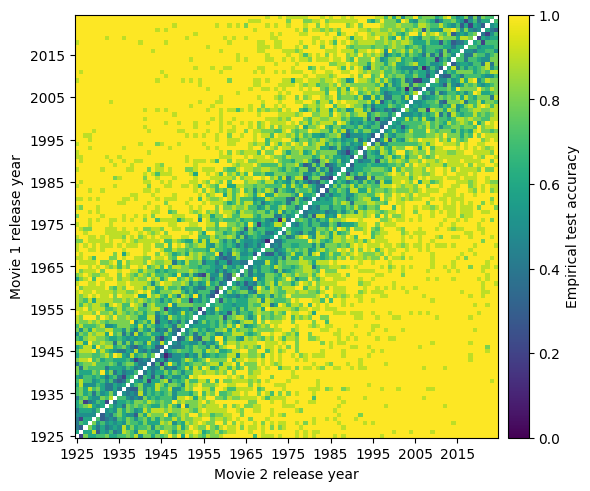

In [184]:
fig, ax = plt.subplots(figsize=(6,6))
cmap = plt.cm.viridis
norm = plt.Normalize(confusion_matrix.min(), confusion_matrix.max())
rgba = cmap(norm(confusion_matrix))
rgba[range(len(confusion_matrix)), range(len(confusion_matrix)), :3] = 1, 1, 1

cax = ax.imshow(rgba, vmin=0, vmax=1)
divider = make_axes_locatable(ax)
cbar_ax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(cax, cax=cbar_ax, label='Empirical test accuracy')

ax.invert_yaxis()
range_number, coef, offset = 10, 10, first_year
ax.set_xticks([coef*i for i in range(range_number)], [coef*i+offset for i in range(range_number)])
ax.set_yticks([coef*i for i in range(range_number)], [coef*i+offset for i in range(range_number)])

ax.set(ylabel='Movie 1 release year', xlabel='Movie 2 release year',
       xticks=[coef*i for i in range(range_number)], yticks=[coef*i for i in range(range_number)],
       xticklabels=[coef*i+offset for i in range(range_number)], yticklabels=[coef*i+offset for i in range(range_number)])
fig.tight_layout()
plt.savefig('report_figures/confusion_matrix.png')
plt.show()

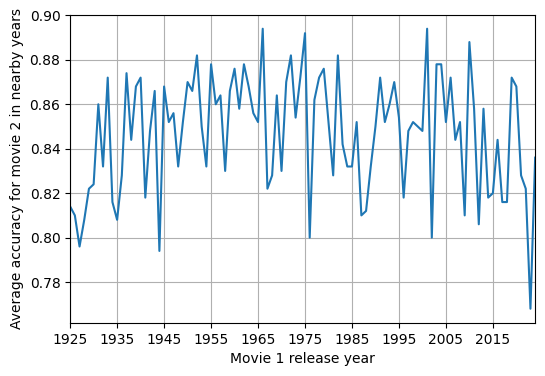

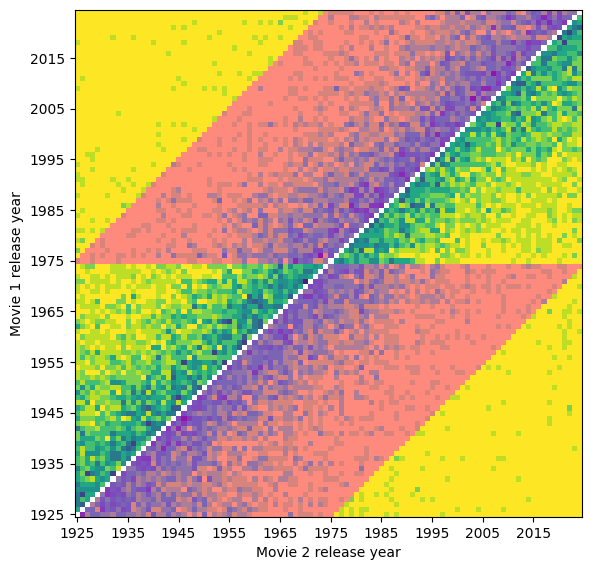

In [185]:
norm_highlighting = plt.Normalize(confusion_matrix.min(), confusion_matrix.max())
rgba_highlighting = cmap(norm_highlighting(confusion_matrix))
color_to_add = np.array([1, 0, 1])
new_color_weight = 0.4

yearly_accs = []
max_half_window_size = 50
for rownum in range(num_years):
    year_correct = 0
    num_valid = 0
    if rownum < num_years // 2:
        year_correct = np.sum(confusion_matrix[rownum, rownum+1:rownum+max_half_window_size+1])
        # num_valid = rownum + max_half_window_size

        rgba_highlighting[rownum, rownum+1:rownum+max_half_window_size+1, :3] = rgba_highlighting[rownum, rownum+1:rownum+max_half_window_size+1, :3] * (1 - new_color_weight) + (new_color_weight * color_to_add)
    else:
        year_correct = np.sum(confusion_matrix[rownum, rownum-max_half_window_size:rownum])
        # num_valid = num_years - rownum + max_half_window_size
        
        rgba_highlighting[rownum, rownum-max_half_window_size:rownum, :3] = rgba_highlighting[rownum, rownum-max_half_window_size:rownum, :3] * (1 - new_color_weight) + (new_color_weight * color_to_add)
    # else:
    #     year_correct = np.sum(confusion_matrix[rownum, rownum-max_half_window_size:rownum+max_half_window_size+1])
    #     num_valid = max_half_window_size * 2 + 1
        
    #     rgba[rownum, rownum-max_half_window_size:rownum+max_half_window_size+1, :3] = rgba[rownum, rownum-max_half_window_size:rownum+max_half_window_size+1, :3] * (1 - new_color_weight) + (new_color_weight * color_to_add)
    yearly_accs.append(year_correct / max_half_window_size / num_per_year)
    rgba_highlighting[rownum, rownum, :3] = 1, 1, 1

plt.figure(figsize=(6,4))
plt.plot(range(first_year, first_year+num_years), yearly_accs)
plt.gca().set(xlabel='Movie 1 release year', ylabel='Average accuracy for movie 2 in nearby years', xticks=[first_year+coef*i for i in range(10)], xlim=[first_year, first_year+num_years-1])
plt.grid()
plt.savefig('report_figures/acc_per_year.png')
plt.show()

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(rgba_highlighting)
ax.invert_yaxis()
range_number, coef, offset = 10, 10, first_year
ax.set_xticks([coef*i for i in range(range_number)], [coef*i+offset for i in range(range_number)])
ax.set_yticks([coef*i for i in range(range_number)], [coef*i+offset for i in range(range_number)])

ax.set(ylabel='Movie 1 release year', xlabel='Movie 2 release year',
       xticks=[coef*i for i in range(range_number)], yticks=[coef*i for i in range(range_number)],
       xticklabels=[coef*i+offset for i in range(range_number)], yticklabels=[coef*i+offset for i in range(range_number)])
fig.tight_layout()
plt.savefig('report_figures/highlighted_cm.png')
plt.show()

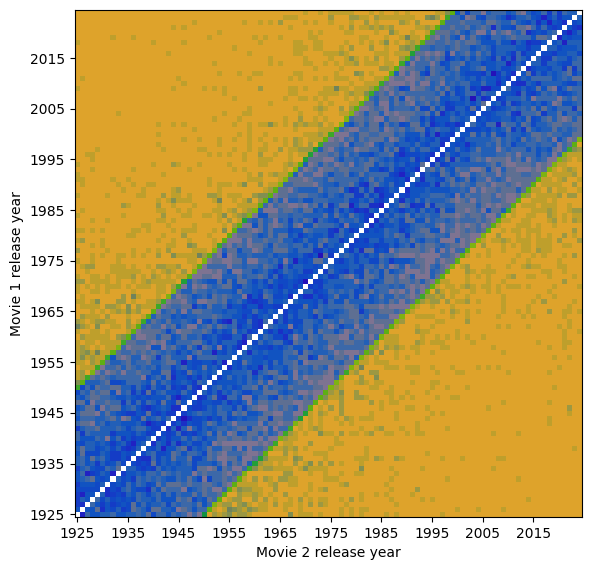

In [217]:
X = 25

rgba = cmap(norm(confusion_matrix))
outside_color, inside_color, online_color, white = np.array([[.75, .375, .2], [0, 0, 1], [0, .5, 0], [1, 1, 1]])
color_weight = 0.5

for rownum in range(num_years):
    row = rgba[rownum, :, :3]
    distances = np.abs(np.arange(len(row)) - rownum)
    
    row[distances < X] = row[distances < X] * (1 - color_weight) + inside_color * color_weight
    row[distances > X] = row[distances > X] * (1 - color_weight) + outside_color * color_weight
    row[distances == X] = row[distances == X] * (1 - color_weight) + online_color * color_weight
    row[rownum] = white

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(rgba)
ax.invert_yaxis()
range_number, coef, offset = 10, 10, first_year
ax.set_xticks([coef*i for i in range(range_number)], [coef*i+offset for i in range(range_number)])
ax.set_yticks([coef*i for i in range(range_number)], [coef*i+offset for i in range(range_number)])

ax.set(ylabel='Movie 1 release year', xlabel='Movie 2 release year',
       xticks=[coef*i for i in range(range_number)], yticks=[coef*i for i in range(range_number)],
       xticklabels=[coef*i+offset for i in range(range_number)], yticklabels=[coef*i+offset for i in range(range_number)])
fig.tight_layout()
plt.savefig(f'report_figures/analysis_interpretation_{X}.png')
plt.show()

#### More analysis and testing

In [48]:
def sum_near_diagonal(matrix, n, num_per_year=10):
    rows, cols = matrix.shape
    near_diagonal_cnt, near_diagonal_total = 0, 0
    far_from_diagonal_cnt, far_from_diagonal_total = 0, 0
    on_diagonal_cnt, on_diagonal_total = 0, 0
    for i in range(rows):
        for j in range(cols):
            if i == j:
                continue
            elif abs(i - j) <= n:
                near_diagonal_cnt += matrix[i, j]
                near_diagonal_total += num_per_year
            else:
                far_from_diagonal_cnt += matrix[i, j]
                far_from_diagonal_total += num_per_year
            if abs(i - j) == n:
                on_diagonal_cnt += matrix[i, j]
                on_diagonal_total += num_per_year

    return (near_diagonal_cnt, near_diagonal_total,
            far_from_diagonal_cnt, far_from_diagonal_total,
            on_diagonal_cnt, on_diagonal_total)

In [210]:
n = 18
close_cnt, close_total, far_cnt, far_total, on_cnt, on_total = sum_near_diagonal(confusion_matrix, n, num_per_year)

overall_model_acc = np.sum(confusion_matrix) / (num_per_year * (confusion_matrix.size - num_years))
print(f'Overall model accuracy: {overall_model_acc*100:.2f}%')

print(f'Accuracy for samples within {n} years of one another: {(close_cnt / close_total)*100:.2f}%')
print(f'Accuracy for samples >{n} years apart: {(far_cnt / far_total)*100:.2f}%')

Overall model accuracy: 86.33%
Accuracy for samples within 18 years of one another: 68.23%
Accuracy for samples >18 years apart: 95.20%


In [51]:
accs_within_n = []
accs_outside_n = []
accs_at_n = []
on_totals = []

for n in range(1, num_years-1):
    close_cnt, close_total, far_cnt, far_total, on_cnt, on_total = sum_near_diagonal(confusion_matrix, n, num_per_year)
    accs_within_n.append(close_cnt / close_total)
    accs_outside_n.append(far_cnt / far_total)
    accs_at_n.append(on_cnt / on_total)
    on_totals.append(on_total)

accs_within_n = np.array(accs_within_n)
accs_outside_n = np.array(accs_outside_n)
accs_at_n = np.array(accs_at_n)

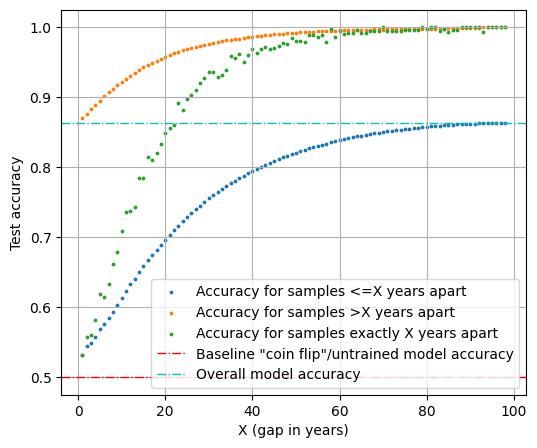

In [183]:
fig = plt.figure(figsize=(6,5))

plt.scatter(range(1, num_years-1), accs_within_n, label='Accuracy for samples <=X years apart', s=3)
plt.scatter(range(1, num_years-1), accs_outside_n, label='Accuracy for samples >X years apart', s=3)
plt.scatter(range(1, num_years-1), accs_at_n, label='Accuracy for samples exactly X years apart', s=3)

plt.axhline(y=.5, color='r', linestyle='-.', lw=1, label='Baseline "coin flip"/untrained model accuracy')
plt.axhline(y=overall_model_acc, color='c', linestyle='-.', lw=1, label='Overall model accuracy')

plt.legend()

plt.xlabel('X (gap in years)')
plt.ylabel('Test accuracy')
plt.grid()
plt.savefig('report_figures/testing_analysis.png')
plt.show()

In [212]:
conf_threshold = 0.9
conf_interval_years = np.where(np.array(accs_outside_n) > conf_threshold)[0][0] + 1
acc_within_that_year = accs_within_n[conf_interval_years-1]
print(conf_interval_years)
print('%.3f%%' % acc_within_that_year)

6
0.577%


In [54]:
np.save('confusion_matrix.npy', confusion_matrix)